In [3]:
import numpy as np
import datetime
import os

In [4]:
n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])
mu_sample = np.reshape(mu_sample,[n_m*n_mu])




def ready_yet(exps, write=False, dry=True, bar=False):
    
    
    root = f"/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/output_nu{'bar' if bar else ''}_NewVol_V2/"
    exps = ["OGTPC1","OGTPC2","OGTPC3","ND280UPGRD","TPC2","TPC3","TPC4","TPC5"]
    bigt = len(exps)*100

    print(str(datetime.datetime.now())+f"; bar={bar}")

    if dry:
        filename = 'dry.txt'
    else:
        filename = 'todo_bar.txt' if bar else 'todo.txt'
        
    with open(filename,'w') as w:
        for exp in exps:
            
            tot = 0

            for i, (m,mu) in enumerate(zip(m_sample, mu_sample)):
                file = f"{exp}_Dipole_M{m:2.2e}_mu{mu:2.2e}_example"
                file1 = file+".parquet"
                file2 = file+".parquet.parquet"
                
                if not os.path.isfile(root+file1) and not os.path.isfile(root+file2):
                    if write:
                        w.write(f'{exp} {m} {mu}\n')
                else: 
                    tot += 1
            print(f'{exp}: {tot} are done out of 100')
            bigt = bigt - tot
    print('-------------------------------')
    print(f'Total of {bigt} instances to be calculated')

In [5]:
exps = ["OGTPC1","OGTPC2","OGTPC3","ND280UPGRD","TPC2","TPC3","TPC4","TPC5"]
ready_yet(exps, write=True, dry=False, bar=True)

2024-11-14 10:46:11.085298; bar=True
OGTPC1: 100 are done out of 100
OGTPC2: 99 are done out of 100
OGTPC3: 100 are done out of 100
ND280UPGRD: 100 are done out of 100
TPC2: 100 are done out of 100
TPC3: 100 are done out of 100
TPC4: 100 are done out of 100
TPC5: 100 are done out of 100
-------------------------------
Total of 1 instances to be calculated


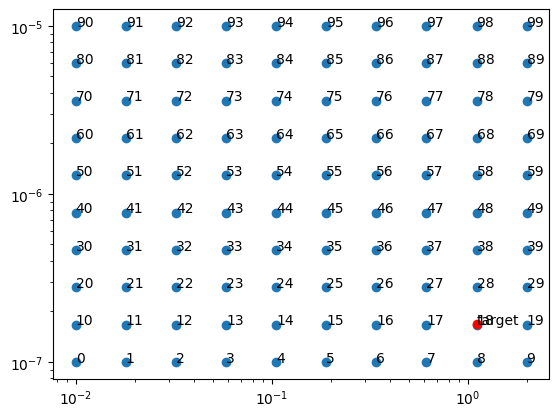

In [2]:
import matplotlib.pyplot as plt
import numpy as np

n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])
mu_sample = np.reshape(mu_sample,[n_m*n_mu])

def plot_samples(m, mu, m_t, mu_t):
    plt.scatter(m, mu)
    plt.scatter(m_t, mu_t, c='r')
    for i, (x,y) in enumerate(zip(m, mu)): plt.annotate(i, (x,y))
    plt.annotate('target', (m_t, mu_t))
    plt.xscale('log'); plt.yscale('log')
    plt.show()
    
plot_samples(m_sample, mu_sample, 1.11e0, 1.67e-07)

In [5]:
import numpy as np
import os
import siren
import multiprocessing
from siren.SIREN_Controller import SIREN_Controller

root = '/n/holyscratch01/arguelles_delgado_lab/Everyone/msliu/TPC_NUBAR'

def HNL_siren(exp, m4, tr4):
    if os.path.isfile(root + f"/output_new/{exp}_Dipole_M{m4:2.2e}_mu{tr4:2.2e}_example.parquet"):
        return
    # Define a DarkNews model
    model_kwargs = {
        "m4": m4,  # 0.140,
        "mu_tr_mu4": tr4,  # 1e-6, # GeV^-1
        "UD4": 0,
        "Umu4": 0,
        "epsilon": 0.0,
        "gD": 0.0,
        "decay_product": "photon",
        "noHC": True,
        "HNLtype": "dirac",
    }

    # Number of events to inject
    events_to_inject = 100000

    # Expeirment to run
    experiment = exp

    # Define the controller
    controller = SIREN_Controller(events_to_inject, experiment)

    # Particle to inject
    primary_type = siren.dataclasses.Particle.ParticleType.NuMu

    xs_path = siren.utilities.get_cross_section_model_path(f"DarkNewsTables-v{siren.utilities.darknews_version()}", must_exist=False)
    # Define DarkNews Model
    table_dir = os.path.join(
        xs_path,
        "Dipole_M%2.2e_mu%2.2e" % (model_kwargs["m4"], model_kwargs["mu_tr_mu4"]),
    )
    controller.InputDarkNewsModel(primary_type, table_dir, **model_kwargs)

    # Primary distributions
    primary_injection_distributions = {}
    primary_physical_distributions = {}

    # energy distribution
    flux_file = siren.utilities.get_tabulated_flux_file("T2K_OLD","MINUS_numubar")
    edist = siren.distributions.TabulatedFluxDistribution(flux_file, True)
    edist_gen = siren.distributions.TabulatedFluxDistribution(
        model_kwargs["m4"], 20, flux_file, False
    )
    primary_injection_distributions["energy"] = edist_gen
    primary_physical_distributions["energy"] = edist

    # direction distribution
    direction_distribution = siren.distributions.FixedDirection(siren.math.Vector3D(0, 0, 1.0))
    primary_injection_distributions["direction"] = direction_distribution
    primary_physical_distributions["direction"] = direction_distribution

    # position distribution
    decay_range_func = siren.distributions.DecayRangeFunction(
        model_kwargs["m4"], controller.DN_min_decay_width, 3, 284.9
    )
    position_distribution = siren.distributions.RangePositionDistribution(
        3.8, 3.8, decay_range_func, set(controller.GetDetectorModelTargets()[0])
    )
    primary_injection_distributions["position"] = position_distribution

    # SetProcesses
    controller.SetProcesses(
        primary_type, primary_injection_distributions, primary_physical_distributions
    )

    controller.Initialize()

    def stop(datum, i):
        secondary_type = datum.record.signature.secondary_types[i]
        return secondary_type != siren.dataclasses.Particle.ParticleType.N4

    controller.injector.SetStoppingCondition(stop)

    events = controller.GenerateEvents(fill_tables_at_exit=False)

    os.makedirs(root+"/output_new", exist_ok=True)

    controller.SaveEvents(
        root+"/output_new/OGTPC1_Dipole_M%2.2e_mu%2.2e_example"
        % (model_kwargs["m4"], model_kwargs["mu_tr_mu4"]),
        fill_tables_at_exit=True
    )

Copy over healthy cross section files

In [7]:
import os
import subprocess

exps, ms, mus = [], [], []
with open('./todo.txt','r') as r:
    for line in r.readlines():
        exp, m, mu = line.strip().split()
        exps.append(exp)
        ms.append(float(m))
        mus.append(float(mu))
        
# Your parameters
a = set([(m,mu) for m, mu in zip(ms, mus)])

source = '/n/home02/msliu/.conda/envs/hnl_inject/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.5'
destination = '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_new/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.7'

def copy_using_rsync(source_dir, dest_dir, mass, mu, dry_run=True):
    """
    Use rsync for recursive copying with detailed progress
    """
    dirname = f'Dipole_M{mass:2.2e}_mu{mu:2.2e}'.replace('+', '')
    source_path = os.path.join(source_dir, dirname) + '/'  # trailing slash is important for rsync
    dest_path = os.path.join(dest_dir, dirname)
    
    # Build rsync command
    # -a: archive mode (recursive, preserves permissions, etc.)
    # -v: verbose
    # -h: human-readable sizes
    # --progress: show progress during transfer
    command = ['rsync', '-avh', '--progress']
    
    if dry_run:
        command.append('--dry-run')
    
    command.extend([source_path, dest_path])
    
    print(f"\nCopying {source_path} to {dest_path}")
    print("Command:", ' '.join(command))
    
    try:
        result = subprocess.run(command, check=True, capture_output=True, text=True)
        print(result.stdout)
        if result.stderr:
            print("Errors:", result.stderr)
        if dry_run:
            print("This was a dry run. No files were actually copied.")
        else:
            print("Copy successful")
    except subprocess.CalledProcessError as e:
        print(f"Error copying: {e.stderr}")

def main(dry_run=True):
    """
    Main function to handle the copying process
    """
    print(f"Source base directory: {source}")
    print(f"Destination base directory: {destination}")
    print(f"Dry run: {dry_run}")
    
    # Create destination directory if it doesn't exist
    os.makedirs(destination, exist_ok=True)
    
    for mass, mu in a:
        print(f"\nProcessing M={mass:2.2e}, mu={mu:2.2e}")
        
        # Choose one method:
        copy_using_rsync(source, destination, mass, mu, dry_run)  # Recommended for Linux/Unix
        
# First do a dry run
print("Performing dry run...")
main(dry_run=True)

# Ask for confirmation before actual copy
response = input("\nWould you like to proceed with the actual copy? (yes/no): ")
if response.lower() == 'yes':
    print("\nPerforming actual copy...")
    main(dry_run=False)
else:
    print("\nCopy cancelled.")

Performing dry run...
Source base directory: /n/home02/msliu/.conda/envs/hnl_inject/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.5
Destination base directory: /n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_new/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.7
Dry run: True

Processing M=1.00e-02, mu=1.00e-07

Copying /n/home02/msliu/.conda/envs/hnl_inject/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.5/Dipole_M1.00e-02_mu1.00e-07/ to /n/holylfs05/LABS/arguelles_delgado_lab/Everyone/msliu/siren_new/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.7/Dipole_M1.00e-02_mu1.00e-07
Command: rsync -avh --progress --dry-run /n/home02/msliu/.conda/envs/hnl_inject/lib/python3.12/site-packages/siren/resources/CrossSections/DarkNewsTables/DarkNewsTables-v0.4.5/Dipole_M1.00e-02_mu1.00e-07/ /n/holylfs0